In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scienceplots
plt.style.use('science')

# FONTS
import sys
from os.path import abspath
source_path = abspath('..')
if not source_path in sys.path:
    sys.path.append(source_path)
    from font import SETTINGS
    for key in SETTINGS:
        plt.rc(key, **SETTINGS[key])

# SEED 
np.random.seed(1)

# PREPARATION

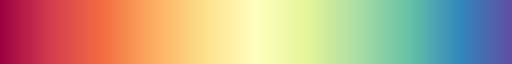

In [2]:
_cmap = plt.get_cmap('Spectral')
_cmap

In [3]:
cmap = _cmap(np.linspace(1, 0, 10)) # start with blue, end with red
len(cmap)

10

In [4]:
COLOR = plt.rcParams['axes.prop_cycle']
COLOR = [v for elem in list(COLOR) for _, v in elem.items()]
COLOR

['#0C5DA5', '#00B945', '#FF9500', '#FF2C00', '#845B97', '#474747', '#9e9e9e']

# FUNCTIONS

In [5]:
DEBUG = 0

In [6]:
def sample_x(mu: float, sigma: float, C: int):
    return np.sort(mu + sigma * np.random.randn(C))
    # return mu + sigma * 2*(np.random.random(C) - 0.5)

def ln(_x):
    _mu = np.mean(_x)
    _std = np.std(_x)
    if DEBUG:
        print(f"mu = {_mu:.2f}, std = {_std:.2f}")
    _y = (_x - _mu)/_std
    return _y

def dyt(_x, Fshift: float, alpha: float):
    argument = [np.float64(alpha) * elem for elem in _x]
    result = np.sqrt(Fshift) * np.tanh(argument)
    return result

def dyisru(_x, Fshift: float, beta: float, mu=None):
    mu_x = np.mean(_x) if mu is None else mu
    x_centralized = [elem - mu_x for elem in _x]
    nominator = np.array([elem**2 for elem in x_centralized])
    denominator = np.array([np.float64(beta)  + elem**2 for elem in x_centralized])
    result = np.sign(_x) * np.sqrt(Fshift) * np.sqrt(nominator / denominator)
    return result

# PLOTS

In [7]:
ALPHA = [0.1, 0.05]
BETA = [100, 500]
COLOR_PLOTS = {'dyt': 'k', 'dyisru': 'k'}
COLOR_PLOTS_ALTERNATIVE = {'dyt': COLOR[4], 'dyisru': COLOR[4]}
LINESTYLE = {'dyt': '--', 'dyisru': '-'}
MARKERSTYLE = {'dyt': 'D', 'dyisru': 's'}
CHANNELS = 50

XLIM = 60
x_values = [np.float64(elem) for elem in np.arange(-XLIM, XLIM, 1)]

NOTE: THIS IS FOR MU=0!


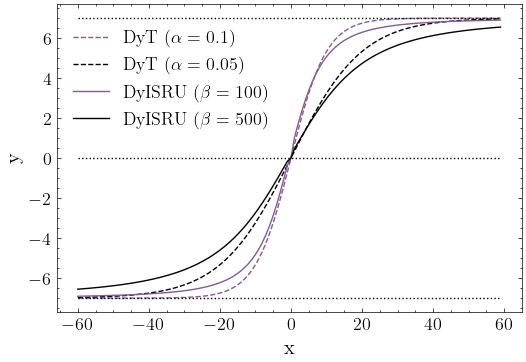

In [8]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax = [ax, None]

# dyt
for i, alpha in enumerate(ALPHA):
    _ = ax[0].plot(
        x_values, 
        dyt(x_values, Fshift=CHANNELS-1, alpha=alpha), 
        linestyle=LINESTYLE['dyt'], 
        marker='', 
        label=fr'DyT ($\alpha = {alpha}$)', 
        color=COLOR_PLOTS_ALTERNATIVE['dyt'] if i == 0 else COLOR_PLOTS['dyt'],
    )

# dyisru
for i, beta in enumerate(BETA):
    _ = ax[0].plot(
        x_values, 
        dyisru(x_values, Fshift=CHANNELS-1, beta=beta), 
        linestyle=LINESTYLE['dyisru'], 
        marker='', 
        label=fr'DyISRU ($\beta = {beta}$)', 
        color=COLOR_PLOTS_ALTERNATIVE['dyisru'] if i == 0 else COLOR_PLOTS['dyisru'],
    )
    
# horizontal lines
_ = ax[0].plot(
    x_values, 
    [np.sqrt(CHANNELS-1)]*len(x_values),
    linestyle=':',
    color='k',
)
_ = ax[0].plot(
    x_values, 
    [0]*len(x_values),
    linestyle=':',
    color='k',
)
_ = ax[0].plot(
    x_values, 
    [-np.sqrt(CHANNELS-1)]*len(x_values),
    linestyle=':',
    color='k',
)

_ = ax[0].set_xlabel('x')
_ = ax[0].set_ylabel('y')
_ = ax[0].legend(loc='upper left', bbox_to_anchor=(0,0.97))

print("NOTE: THIS IS FOR MU=0!")

plt.savefig('figs/plots.png', bbox_inches='tight')

# SIMULATION

In [9]:
CLR = [cmap[i] for i in range(len(cmap))]
CLR

[array([0.36862745, 0.30980392, 0.63529412, 1.        ]),
 array([0.21607074, 0.55563245, 0.73194925, 1.        ]),
 array([0.45305652, 0.78154556, 0.64628989, 1.        ]),
 array([0.74771242, 0.89803922, 0.62745098, 1.        ]),
 array([0.94425221, 0.97770088, 0.66205306, 1.        ]),
 array([0.99777009, 0.93087274, 0.63306421, 1.        ]),
 array([0.99346405, 0.74771242, 0.43529412, 1.        ]),
 array([0.96378316, 0.47743176, 0.28581315, 1.        ]),
 array([0.84721261, 0.26120723, 0.30519031, 1.        ]),
 array([0.61960784, 0.00392157, 0.25882353, 1.        ])]

In [10]:
MU = [0]
SIGMA = [2]
C = [100] * len(MU) 

In [11]:
x = [sample_x(mu=_mu, sigma=_sigma, C=_C) for _mu, _sigma, _C in zip(MU, SIGMA, C)]
y_ln = [ln(elem) for elem in x]

In [12]:
def plot(x_input, y_ln_input, nr_steps=0, plot_functions: bool = False, plot_symmetric: bool = False, legend_steps: bool = True, savefig: bool = False, alpha=None, beta=None):

    x = x_input.copy()
    y_ln = y_ln_input.copy()
    
    for i in range(nr_steps):
        x.append(x[0].copy())
        x[i+1][-1] += 5*(i+1)
        y_ln.append(ln(x[i+1]))

    outliers = {'i': [], 'x': [], 'y': []}

    fig, ax = plt.subplots(1,1,figsize=(6,4))
    ax = [ax, None]

    # functions
    if plot_functions:
        if alpha is None:
            alpha = 0.1
        _ = ax[0].plot(
            x_values, 
            dyt(x_values, Fshift=C[0]-1, alpha=alpha), 
            linestyle=LINESTYLE['dyt'], 
            marker='', 
            label=fr'DyT ($\alpha = {alpha:.3f}$)', 
            color=COLOR_PLOTS['dyt'],
        )
        if beta is None:
            beta = 120
        _ = ax[0].plot(
            x_values, 
            dyisru(x_values, Fshift=C[0]-1, beta=beta, mu=0), 
            linestyle=LINESTYLE['dyisru'], 
            marker='', 
            label=fr'DyISRU ($\beta = {beta:.1f}$)',
            color=COLOR_PLOTS['dyisru'],
        )
        # horizontal lines
        _ = ax[0].plot(
            x_values, 
            [np.sqrt(C[0]-1)]*len(x_values),
            linestyle=':',
            color='k',
        )
        _ = ax[0].plot(
            x_values, 
            [-np.sqrt(C[0]-1)]*len(x_values),
            linestyle=':',
            color='k',
        )

    # data
    for i, (_x, _y_ln) in enumerate(zip(x, y_ln)):
        if i == len(y_ln) - 1:
           print(f"LAST POINT: i = {i}, y={_y_ln[-1]}")
        _ = ax[0].plot(
            _x[:-1], 
            _y_ln[:-1], 
            linestyle='', 
            marker='o', 
            markerfacecolor='w', 
            color=CLR[i % len(CLR)] if plot_symmetric is False else 'gray',
        )
        _ = ax[0].plot(
            _x[-1:], 
            _y_ln[-1:], 
            linestyle='', 
            marker='o', 
            markerfacecolor=CLR[i % len(CLR)] if i > 0 else 'w', 
            label=f'S = {i}' if legend_steps else None, 
            color=CLR[i % len(CLR)],
        )
        if plot_symmetric:
            _ = ax[0].plot(
                -_x[:-1], 
                -_y_ln[:-1], 
                linestyle='', 
                marker='o', 
                markerfacecolor='w', 
                color=CLR[i % len(CLR)] if plot_symmetric is False else 'gray',
            )
            _ = ax[0].plot(
                -_x[-1:], 
                -_y_ln[-1:], 
                linestyle='', 
                marker='o', 
                markerfacecolor=CLR[i % len(CLR)] if i > 0 else 'w', 
                label=f'S = {i}' if legend_steps else None, 
                color=CLR[i % len(CLR)],
            )
            
        if i > 0:
            outliers['i'].append(i)
            outliers['x'].append(float(_x[-1]))
            outliers['y'].append(float(_y_ln[-1]))

    _ = ax[0].legend(loc='upper left', bbox_to_anchor=(0,0.97))
    _ = ax[0].set_xlabel('x')
    _ = ax[0].set_ylabel('y')
    _ = ax[0].set_xlim(-55, 55)
    _ = ax[0].set_ylim(-11, 11)
    
    if savefig:
        file_path = f'figs/simulation_{nr_steps}_fits.png' if plot_functions else f'figs/simulation_{nr_steps}.png'
        plt.savefig(file_path, bbox_inches='tight')
        
    return outliers

LAST POINT: i = 0, y=2.40069777656419


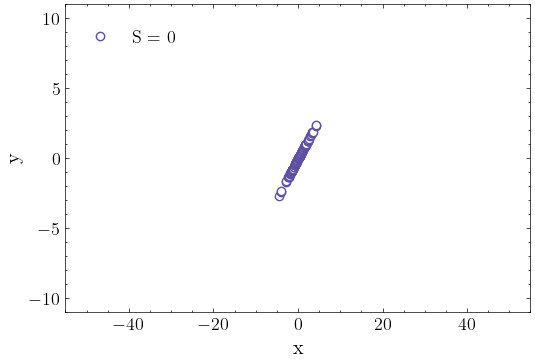

In [13]:
_ = plot(x, y_ln, nr_steps=0, savefig=True)

LAST POINT: i = 1, y=4.715458692519567


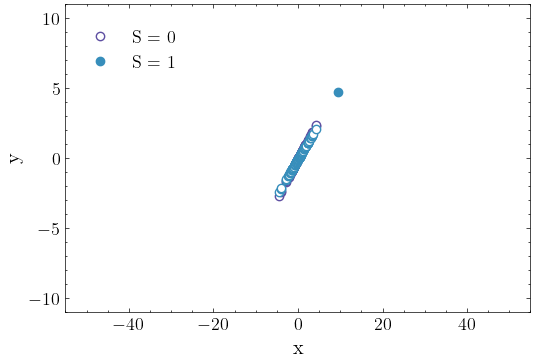

In [14]:
_ = plot(x, y_ln, nr_steps=1, savefig=True)

LAST POINT: i = 2, y=6.344581148008157


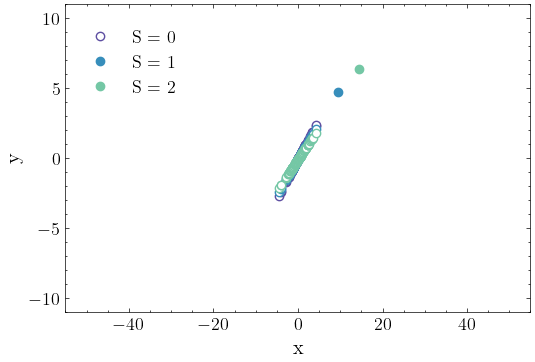

In [15]:
_ = plot(x, y_ln, nr_steps=2, savefig=True)

LAST POINT: i = 9, y=9.390432522317097


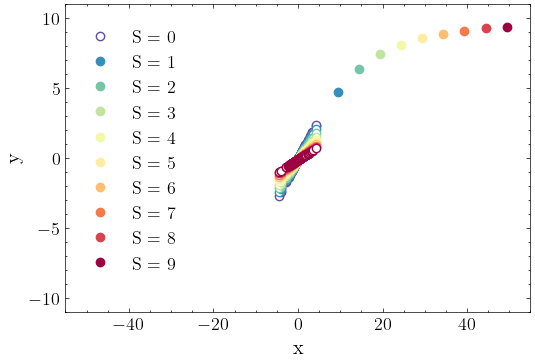

In [16]:
outliers = plot(x, y_ln, nr_steps=9, savefig=True, plot_functions=False)

# FIT

## Data

In [17]:
outliers['x']

[9.371150813066322,
 14.371150813066322,
 19.371150813066322,
 24.371150813066322,
 29.371150813066322,
 34.37115081306632,
 39.37115081306632,
 44.37115081306632,
 49.37115081306632]

In [18]:
outliers['y']

[4.715458692519567,
 6.344581148008157,
 7.414185131923001,
 8.1100135128233,
 8.571591081005568,
 8.886944326366176,
 9.109168615543917,
 9.270383271697186,
 9.390432522317097]

In [19]:
# symmetric data
data = {
    'x': [-elem for elem in outliers['x'][::-1]] + outliers['x'],
    'y': [-elem for elem in outliers['y'][::-1]] + outliers['y'],
}

## Fit

In [20]:
mean_abs_residual, residuals = {}, {}

In [21]:
def fit_dyt(_x, alpha):
    return dyt(_x, 100-1, alpha)

def fit_dyisru(_x, beta):
    return dyisru(_x, 100-1, beta, mu=0)

def get_mean_abs_residual(_infodict):
    residuals = _infodict['fvec']
    abs_residuals = np.abs(residuals)
    mean_abs_residual = np.mean(abs_residuals)
    return mean_abs_residual, residuals

In [22]:
popt, _, infodict, mesg, ier = curve_fit(fit_dyt, data['x'], data['y'], full_output=True, p0=[0.1]) # , bounds=(0, 10))
alpha = popt[0]
alpha

np.float64(0.048610098601027746)

In [23]:
mean_abs_residual['dyt'], residuals['dyt'] = get_mean_abs_residual(infodict)
mean_abs_residual['dyt'], residuals['dyt']

(np.float64(0.32787701391535035),
 array([-0.39698827, -0.41669035, -0.41690456, -0.38290985, -0.29575086,
        -0.13766509,  0.09135734,  0.34015416,  0.47247264, -0.47247264,
        -0.34015416, -0.09135734,  0.13766509,  0.29575086,  0.38290985,
         0.41690456,  0.41669035,  0.39698827]))

In [24]:
popt, _, infodict, mesg, ier = curve_fit(fit_dyisru, data['x'], data['y'], full_output=True, p0=[800]) # , bounds=(0, 1000))
beta = popt[0]
beta

np.float64(301.0599538956246)

In [25]:
mean_abs_residual['dyisru'], residuals['dyisru'] = get_mean_abs_residual(infodict)
mean_abs_residual['dyisru'], residuals['dyisru']

(np.float64(0.004814208472057737),
 array([ 0.00338782,  0.00381666,  0.00426825,  0.00467986,  0.00489262,
         0.00452908,  0.00274057, -0.00218718, -0.01282583,  0.01282583,
         0.00218718, -0.00274057, -0.00452908, -0.00489262, -0.00467986,
        -0.00426825, -0.00381666, -0.00338782]))

LAST POINT: i = 9, y=9.390432522317097


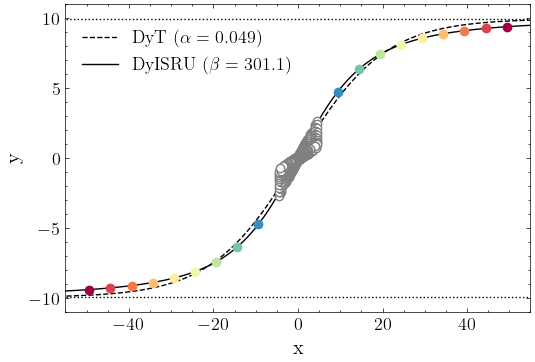

In [26]:
_ = plot(x, y_ln, nr_steps=9, savefig=True, legend_steps=False, plot_functions=True, plot_symmetric=True, alpha=alpha, beta=beta)

## Residuals

In [27]:
def plot_residuals(_data, _mean_abs_residual, _residuals, savefig: bool = False):
    fig, ax = plt.subplots(1,1,figsize=(6,2))
    ax = [ax, None]

    start_index = int(len(_data['x'])/2)
    end_index = len(_data['x'])

    _ = ax[0].plot(
        [-55, 55], 
        [0]*2,
        linestyle=':',
        color='k',
    )
    for dyx in ['dyt', 'dyisru']:
        if dyx == 'dyt':
            label = fr'DyT ($\alpha = {alpha:.3f}$)'
        elif dyx == 'dyisru':
            label = fr'DyISRU ($\beta = {beta:.1f}$)'
            
        _ = ax[0].plot(
                _data['x'][start_index:],
                _residuals[dyx][start_index:],
                linestyle=LINESTYLE[dyx], 
                marker=MARKERSTYLE[dyx],
                label=label,
                color=COLOR_PLOTS[dyx],
            )
        
        for i in range(start_index, end_index):               
            _ = ax[0].plot(
                _data['x'][i],
                _residuals[dyx][i],
                linestyle='', 
                marker=MARKERSTYLE[dyx],
                color=CLR[(i + 1 - start_index) % len(CLR)],
            )

    
    _ = ax[0].legend(loc='upper left', bbox_to_anchor=(0,0.97))
    _ = ax[0].set_xlabel('x')
    _ = ax[0].set_ylabel('residual')
    _ = ax[0].set_xlim(-55, 55)
    ylim = ax[0].get_ylim()
    ylim_new = np.max(np.abs(ylim))
    _ = ax[0].set_ylim(-ylim_new, ylim_new)
    
    if savefig:
        file_path = f'figs/simulation_residuals.png'
        plt.savefig(file_path, bbox_inches='tight')

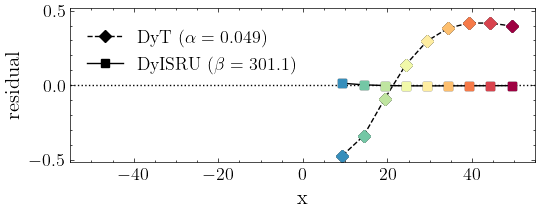

In [28]:
plot_residuals(data, mean_abs_residual, residuals, savefig=True)